In this notebook, we will try to train a Random Forest model using permissions from 4287 benign and 3876 malicious android applications.

<h1>Loading Data</h1>

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

In [11]:
permissions_df = pd.read_csv('../catch-o-extractor/extracted_permissions.csv')
labeled_data_df = pd.read_csv('../catch-o-labeler/labeled_data.csv')

permissions_df = permissions_df.drop(permissions_df.columns[1], axis=1)
permissions_df = permissions_df.rename(columns={permissions_df.columns[0]: 'name'})

In [12]:
df = permissions_df.merge(labeled_data_df, left_on='name', right_on='hash', how='left')

df['detection'] = df['detection'].fillna('benign')

df = df.drop(columns=['hash'])


In [13]:
# Remove rows where detection is 'ransomware'
df = df[df['detection'] != 'ransomware']
df = df[df['detection'] != 'other']
# RF does not combine well with 3 samples from a class
df['detection'].value_counts()

detection
benign      4298
trojan      3179
adware       325
spyware       66
exploit       32
rootkit       11
hacktool       8
Name: count, dtype: int64

In [14]:
# Separate features and labels
X = df.iloc[:, 1:-1]
y = df.iloc[:, -1]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


<h1>Training the RF Classifier</h1>

In [16]:
# Initialize and train the Random Forest classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# Generate predictions
y_pred = rf_clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Print the classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.9261363636363636
              precision    recall  f1-score   support

      adware       0.83      0.21      0.34        71
      benign       0.97      0.98      0.98       861
     exploit       1.00      0.11      0.20         9
    hacktool       0.00      0.00      0.00         2
     rootkit       0.00      0.00      0.00         3
     spyware       0.78      0.39      0.52        18
      trojan       0.87      0.97      0.92       620

    accuracy                           0.93      1584
   macro avg       0.64      0.38      0.42      1584
weighted avg       0.92      0.93      0.91      1584



/home/kreunt/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kreunt/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kreunt/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [17]:
unique_classes = ['adware', 'benign', 'exploit', 'hacktool', 'rootkit', 'spyware', 'trojan']

print(unique_classes)

['adware', 'benign', 'exploit', 'hacktool', 'rootkit', 'spyware', 'trojan']


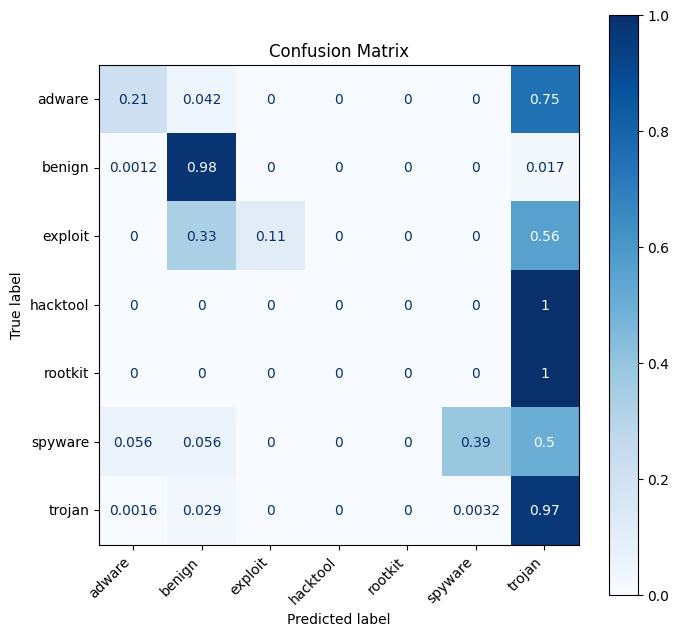

In [18]:
# Create confusion matrix display
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figure size
disp = ConfusionMatrixDisplay.from_estimator(rf_clf, X_test, y_test, display_labels=unique_classes, cmap=plt.cm.Blues, normalize='true', ax=ax)

# Adjust label positions
plt.xticks(rotation=45, ha='right')
plt.yticks(va='center')

# Add some padding between the plot and the labels
plt.subplots_adjust(bottom=0.3, left=0.3)

plt.title("Confusion Matrix")
plt.show()

<h1>Handling Class Imbalance with SMOTE</h1>

In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the dataset
smote = SMOTE(k_neighbors=2)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Re-train the Random Forest classifier with balanced data
rf_clf.fit(X_resampled, y_resampled)

# Generate predictions
y_pred = rf_clf.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      adware       0.39      0.46      0.42        65
      benign       0.98      0.64      0.77       848
     exploit       0.11      0.57      0.19         7
    hacktool       0.00      0.00      0.00         0
       other       0.26      0.29      0.28        51
     rootkit       0.00      0.00      0.00         2
     spyware       0.18      0.18      0.18        11
      trojan       0.89      0.89      0.89       649

    accuracy                           0.72      1633
   macro avg       0.35      0.38      0.34      1633
weighted avg       0.89      0.72      0.78      1633



/home/kreunt/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kreunt/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kreunt/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ValueError: The number of FixedLocator locations (8), usually from a call to set_ticks, does not match the number of labels (7).

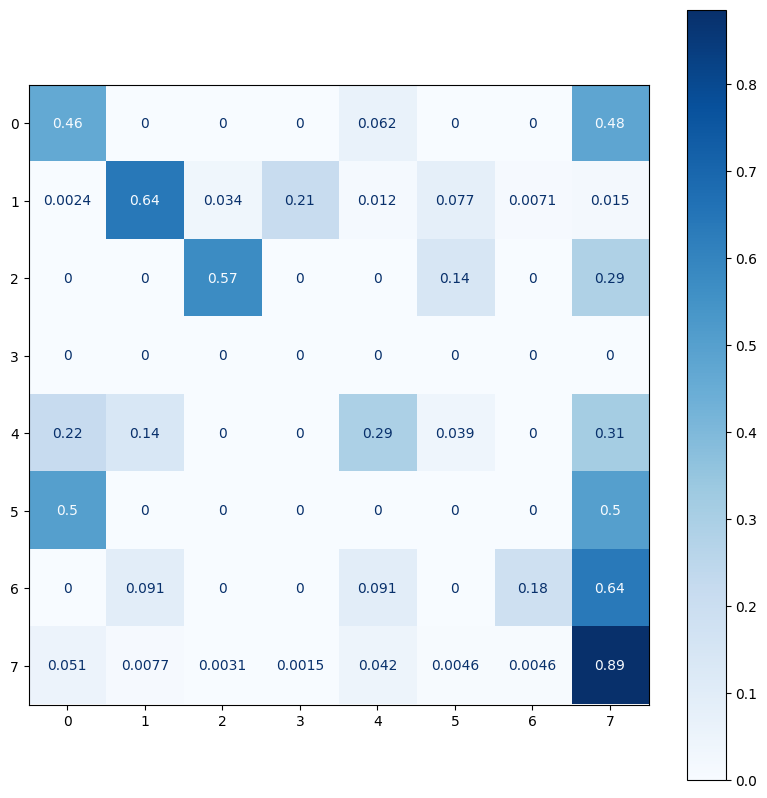

In [ ]:
# Plot confusion matrix
unique_classes = y_test.unique()

# Create confusion matrix display
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figure size
disp = ConfusionMatrixDisplay.from_estimator(rf_clf, X_test, y_test, display_labels=unique_classes, cmap=plt.cm.Blues, normalize='true', ax=ax)

# Adjust label positions
plt.xticks(rotation=45, ha='right')
plt.yticks(va='center')

# Add some padding between the plot and the labels
plt.subplots_adjust(bottom=0.3, left=0.3)

plt.title("Confusion Matrix")
plt.show()